In [1]:
import os
os.chdir('..')

In [2]:
import torch
import pickle
import numpy as np

from gnn_library.util import load
from evaluate import evaluate_model
from instance_generator import sample_instances
from params import *
from util import _plot_approx_ratios_all, _plot_approx_ratios

%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

GNN, args = load('GNN_large_10_6', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:6


## Size generalization experiment

#### Evaluate CRs for all graph configurations across different graph sizes

In [4]:
import gc # TODO remove
rng = np.random.default_rng(seed=0)
num_trials = 150
batch_size = 500
graph_configs = ALL_TESTING_GRAPH_CONFIGS
node_configs = EXPERIMENT_SIZE_GENERALIZATION_REGIMES
print(node_configs)
sizes = [x+y for (x,y) in node_configs]
baselines_kwargs = {
    'greedy': {},
    'greedy_t': {'threshold': 0.35},
    'lp_rounding': {'rng': rng}
}

data = [[] for _ in range(len(graph_configs))]



# for i, node_config in enumerate(node_configs):
#     for data_index, graph_config in enumerate(graph_configs):
#         print(node_config, graph_config)
        
#         instances = sample_instances(
#             *node_config,
#             num_trials,
#             rng,
#             args.__dict__,
#             **graph_config
#         )

#         cr_ratios, _ = evaluate_model(
#             meta_model=None,
#             meta_model_type=None,
#             base_models=[GNN],
#             instances=instances,
#             batch_size=batch_size,
#             rng=rng,
#             num_realizations=5,
#             baselines=['greedy', 'greedy_t', 'lp_rounding'],
#             **baselines_kwargs
#         )
#         data[data_index].append(cr_ratios)
    

#         with open(f"experiments/size_generalization_main1.pickle", 'wb') as handle:
#             pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

#         gc.collect()
#         torch.cuda.empty_cache()

[(20, 10), (24, 12), (28, 14), (32, 16), (36, 18), (40, 20), (44, 22), (48, 24), (52, 26), (56, 28), (60, 30), (64, 32), (68, 34), (72, 36), (76, 38), (80, 40), (84, 42), (88, 44), (92, 46), (96, 48), (100, 50), (104, 52), (108, 54), (112, 56), (116, 58), (120, 60), (124, 62), (128, 64), (132, 66), (136, 68), (140, 70), (144, 72), (148, 74), (152, 76), (156, 78), (160, 80), (164, 82), (168, 84), (172, 86), (176, 88), (180, 90), (184, 92), (188, 94)]


#### Generate size generalization plots

22


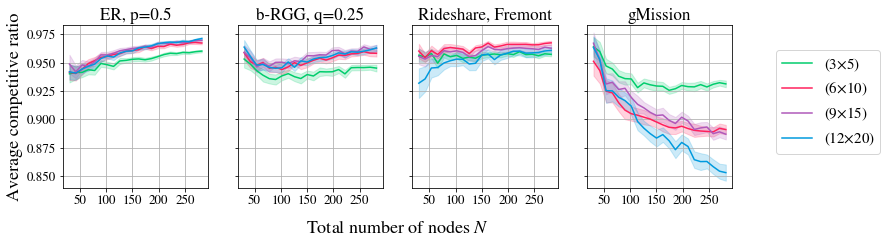

In [13]:
from util import _plot_approx_ratios

# with open(f"experiments/size_generalization_all_merged.pickle", 'rb') as handle:
with open(f"experiments/diff_training_size_generalization_all.pickle", 'rb') as handle:
    results = pickle.load(handle)
print(len(results[3]))

graph_configs = MAIN_TESTING_GRAPH_CONFIGS
node_configs = EXPERIMENT_SIZE_GENERALIZATION_REGIMES
sizes = [x+y for (x,y) in node_configs]

# filtered_results = []
# for data_index, graph_config in enumerate(ALL_TESTING_GRAPH_CONFIGS):
#     if graph_config in SMALL_TESTING_GRAPH_CONFIGS:
#         filtered_results.append(results[data_index])
# results = filtered_results

node_configs = [(2*x, x) for x in np.arange(10, 95, 4)]
sizes = [x+y for (x,y) in node_configs]


filtered_results = {frozenset(g.items()): data for g, data in zip(graph_configs, results)}
_plot_approx_ratios(sizes, filtered_results, x_axis_name= "Total number of nodes $N$", confidence = 0.95)